In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
# env.close()
env = UnityEnvironment(file_name='Reacher_Linux_NoVis20/Reacher.x86_64')
# env = UnityEnvironment(file_name='Reacher20.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
# print(brain.vector_)
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# print(states)
actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
# print(actions)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


In [6]:
env_info = env.reset(train_mode=True)[brain_name]

In [7]:
# Two networks
# Actor:
# * Takes in State, outputs probability distribution over actions
# * Get action A to take from given state S
# * Observe result of taking A, yielding reward R and new state S'
# * now we have a tuple (S,A,R,S')
# * Hand (S,A,R,S') off to critic to estimate r + \gamma * V(s';\theta)

import random
import torch
import numpy as np
from collections import deque
import copy
from collections import namedtuple
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 1200       # minibatch size
GAMMA = 0.99         # discount factor
MAX_TAU = 5e-4              # for soft update of target parameters
MIN_TAU = 1e-5
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 5e-4        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [8]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(
            self.bn1(
                self.fc1(state)))
        x = F.relu(
            self.bn2(
                self.fc2(x)))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        #JODO: Why is the output only one value???
        # Answer: It is the expected value of taking `action` given `state`
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        #JODO: Why reset parameters? When do we do it?
        # Answer: when the network is first instantiated.
        # What is uniform_ ?
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.relu(
            self.bn1(
                self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(
            self.bn2(
                self.fc2(x)))
        return self.fc3(x)


In [9]:
class Agent():
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.replay_buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.tau = MAX_TAU
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.replay_buffer.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.replay_buffer) > BATCH_SIZE:
            experiences = self.replay_buffer.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval() # Sets "train" to False
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy() # this calls Actor#forward
        self.actor_local.train() # Sets "train" to True
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_future = self.actor_target(next_states)
        Q_future = self.critic_target(next_states, actions_future)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_future * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        # Why is this the actor loss??
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
#         print(self.mu, self.theta, self.sigma, random.gauss(self.mu, self.sigma));raise
#         dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * random.gauss(self.mu, self.sigma)/2
#         print(dx);raise
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        for i in range(len(state)):
            e = self.experience(state[i], action[i], reward[i], next_state[i], done[i])
            self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
agent = Agent(state_size=33, action_size=4, random_seed=2)

In [11]:
import os
# 11/21 18:40: 4.64 after 100
# 11/21 19:58: 7.50 after 100 w BatchNorm on Critic
# 11/21 20:51: 0.93 after 30 w TAU=1e-4
# 11/21 22:15: 5.75 after 100 w TAU=1e-3, LR_ACTOR=1e-4, LR_CRITIC=1e-4, BATCH_SIZE=1024
# 11/22 02:30: 9.55 after 1000 w TAU=1e-4
# TODO:
# * Check Noise implementation
# * 
scores = []
def ddpg(n_episodes=2000, max_t=50000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    for i_episode in range(1, n_episodes+1):
        if agent.tau > MIN_TAU:
            agent.tau = agent.tau - 0.02 * (agent.tau - MIN_TAU)
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = 0
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished               # update the score (for each agent)
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += np.mean(rewards)
            if max(dones):
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tSCORE={}\tTAU={}\tAVG={:.2f}'.format(
            i_episode, score, agent.tau, np.mean(scores_deque)), end="")
        os.write(1, '\rEpisode {}\tSCORE={}\tTAU={}\tAVG={:.2f}'.format(
            i_episode, score, agent.tau, np.mean(scores_deque)).encode())
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

ddpg()


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 16.791014	TAU=7.498358238842906e-05	AVG=16.79
Episode 171	SCORE=37.23899916764368	TAU=2.548299677913605e-05	AVG=30.1710

KeyboardInterrupt: 

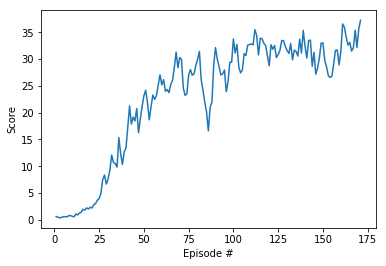

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [18]:
sum(scores[-100:])/len(scores[-100:])
# agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
# agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

# state = env.reset()
# for t in range(200):
#     action = agent.act(state, add_noise=False)
#     env.render()
#     state, reward, done, _ = env.step(action)[brain_name]
#     if done:
#         break 

30.16921932566539